# **Importing dependencies**

In [1]:
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision import datasets
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import torch

# **Data preparation**

In [2]:
train_folder= r'C:\PROJECTS\AI\FINE GRAINED\FINE GRAINED DATA\NEU-DET-COCO\MECHA\train'
val_folder= r'C:\PROJECTS\AI\FINE GRAINED\FINE GRAINED DATA\NEU-DET-COCO\MECHA\val'
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_dataset = datasets.ImageFolder(root= train_folder, transform=transform)
val_dataset = datasets.ImageFolder(root= val_folder, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 5 , shuffle= True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 5 , shuffle= False)

# **Functions for triplet loss computing**
In this section we are going to use the following functions to perform sample mining. The method of mining used below is the batch all triplet mining. It involves computing the triplet loss for all possible combinations of anchor, positive, and negative samples in a batch.






In [3]:
def euclidean_distance(x, y):
    return torch.pow(x - y, 2).sum(dim=1)

# Compute triplet loss using the batch all strategy
def batch_all_triplet_loss(anchor, positive, negative, margin=0.3):
    positive_distance = euclidean_distance(anchor, positive)
    negative_distance = euclidean_distance(anchor, negative)
    loss = torch.clamp(positive_distance - negative_distance + margin, min=0.0)
    return loss.mean()

In [4]:
# Triplet dataset class
class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.classes = dataset.classes
        self.class_to_idx = dataset.class_to_idx
        self.data = dataset.samples
        self.targets = [s[1] for s in dataset.samples]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.dataset[idx]
        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(
                [i for i, t in enumerate(self.targets) if t == anchor_label])
        positive_img, _ = self.dataset[positive_idx]
        negative_idx = np.random.choice(
            [i for i, t in enumerate(self.targets) if t != anchor_label])
        negative_img, _ = self.dataset[negative_idx]
        return anchor_img, positive_img, negative_img


# **Embbedings**

In [5]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 50 * 50, 128)
        self.fc2 = nn.Linear(128, 6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax here
        return x

In [6]:
train_triplet_dataset = TripletDataset(train_dataset)
val_triplet_dataset = TripletDataset(val_dataset)
train_loader = DataLoader(train_triplet_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=5, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_model = EmbeddingModel().to(device)
optimizer = optim.Adam(embedding_model.parameters(), lr=0.0001)

In [7]:
def train_epoch(model, optimizer, train_loader, device, margin=0.3):
    model.train()
    running_loss = 0.0
    for batch_idx, (anchor, positive, negative) in enumerate(train_loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_embed = model(anchor)
        positive_embed = model(positive)
        negative_embed = model(negative)
        loss = batch_all_triplet_loss(anchor_embed, positive_embed, negative_embed, margin)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item()}')
    return running_loss / len(train_loader)

def validate_epoch(model, val_loader, device, margin=0.3):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in enumerate(val_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            loss = batch_all_triplet_loss(anchor_embed, positive_embed, negative_embed, margin)
            running_loss += loss.item()
            dist_ap = euclidean_distance(anchor_embed, positive_embed)
            dist_an = euclidean_distance(anchor_embed, negative_embed)
            correct += (dist_ap < dist_an).sum().item()
            total += anchor.size(0)
    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [8]:
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(1, num_epochs + 1):
    avg_train_loss = train_epoch(embedding_model, optimizer, train_loader, device)
    avg_val_loss, val_accuracy = validate_epoch(embedding_model, val_loader, device)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch}, Average Training Loss: {avg_train_loss:.4f}')
    print(f'Epoch {epoch}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

Batch 0, Loss: 0.29952701926231384
Batch 100, Loss: 0.0
Batch 200, Loss: 0.013247191905975342
Epoch 1, Average Training Loss: 0.1162
Epoch 1, Validation Loss: 0.0816, Validation Accuracy: 87.78%
Batch 0, Loss: 0.0
Batch 100, Loss: 0.0
Batch 200, Loss: 0.09168954193592072
Epoch 2, Average Training Loss: 0.0715
Epoch 2, Validation Loss: 0.0578, Validation Accuracy: 90.56%
Batch 0, Loss: 0.07076328992843628
Batch 100, Loss: 0.011453467421233654
Batch 200, Loss: 0.03324752300977707
Epoch 3, Average Training Loss: 0.0709
Epoch 3, Validation Loss: 0.0931, Validation Accuracy: 88.33%
Batch 0, Loss: 0.0
Batch 100, Loss: 0.025285590440034866
Batch 200, Loss: 0.09295234829187393
Epoch 4, Average Training Loss: 0.0568
Epoch 4, Validation Loss: 0.1054, Validation Accuracy: 89.44%
Batch 0, Loss: 0.0
Batch 100, Loss: 0.0
Batch 200, Loss: 0.0
Epoch 5, Average Training Loss: 0.0675
Epoch 5, Validation Loss: 0.0764, Validation Accuracy: 87.78%
Batch 0, Loss: 0.030478447675704956
Batch 100, Loss: 0.0520

Epoch 45, Average Training Loss: 0.0285
Epoch 45, Validation Loss: 0.0655, Validation Accuracy: 91.11%
Batch 0, Loss: 0.0
Batch 100, Loss: 0.12213301658630371
Batch 200, Loss: 0.07835493981838226
Epoch 46, Average Training Loss: 0.0218
Epoch 46, Validation Loss: 0.0385, Validation Accuracy: 93.89%
Batch 0, Loss: 0.1467137485742569
Batch 100, Loss: 0.0
Batch 200, Loss: 0.10173334926366806
Epoch 47, Average Training Loss: 0.0237
Epoch 47, Validation Loss: 0.0445, Validation Accuracy: 94.44%
Batch 0, Loss: 0.0
Batch 100, Loss: 0.0
Batch 200, Loss: 0.10317907482385635
Epoch 48, Average Training Loss: 0.0322
Epoch 48, Validation Loss: 0.0535, Validation Accuracy: 93.33%
Batch 0, Loss: 0.11536037921905518
Batch 100, Loss: 0.0
Batch 200, Loss: 0.0
Epoch 49, Average Training Loss: 0.0253
Epoch 49, Validation Loss: 0.0286, Validation Accuracy: 96.11%
Batch 0, Loss: 0.0
Batch 100, Loss: 0.0
Batch 200, Loss: 0.14166636765003204
Epoch 50, Average Training Loss: 0.0261
Epoch 50, Validation Loss: 0.

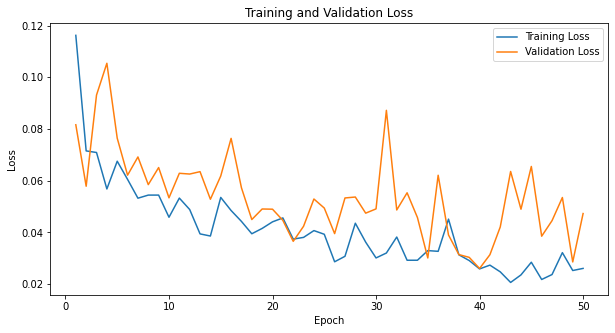

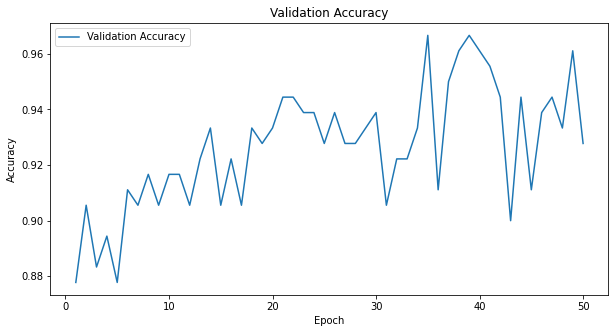

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [10]:
torch.save(embedding_model.state_dict(), 'state_dict_model.pt')

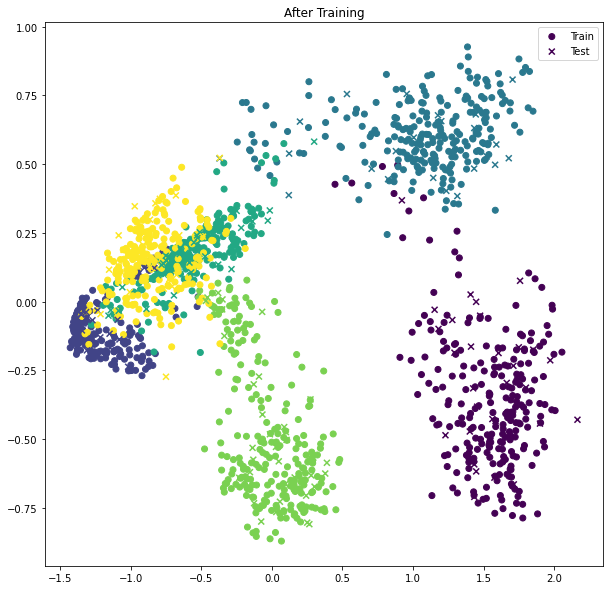

In [11]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

train_folder = r'C:\PROJECTS\AI\FINE GRAINED\FINE GRAINED DATA\NEU-DET-COCO\MECHA\train'
test_folder = r'C:\PROJECTS\AI\FINE GRAINED\FINE GRAINED DATA\NEU-DET-COCO\MECHA\test'
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_model = EmbeddingModel().to(device)
embedding_model.load_state_dict(torch.load('state_dict_model.pt'))
embedding_model.eval()

def extract_embeddings(model, loader, device):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            output = model(images)
            embeddings.append(output.cpu().numpy())
            labels.append(targets.numpy())
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(embedding_model, train_loader, device)
test_embeddings, test_labels = extract_embeddings(embedding_model, test_loader, device)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, train_labels)
test_predictions = knn.predict(test_embeddings)

from sklearn.decomposition import PCA

pca = PCA(n_components=5)
train_embeddings_2d = pca.fit_transform(train_embeddings)
test_embeddings_2d = pca.transform(test_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], c=train_labels, marker='o', label='Train')
plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], c=test_predictions, marker='x', label='Test')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
plt.title('After Training')
plt.legend()
plt.show()

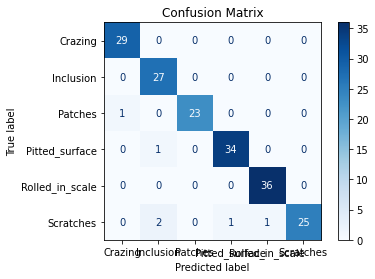

In [12]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()